In [165]:
%matplotlib inline
import time

In [311]:
Drive = 0.15
S_lifetime = 440.0
E1_lifetime = 12.5
E2_lifetime = 12.5

# P,M,Z,S,E1,E2
drive_branching = normalized([1,0])
E1_branching = normalized([0.94,0.01,0.5,0.0,0.0,0.0]) + np.array([0.0,0.0,0.0,0.5,0,0])
E2_branching = normalized([0.90,0.01,0.5,0.0,0.0,0.0]) + np.array([0.0,0.0,0.0,0.5,0,0])
S_branching = normalized([1,1,2,0,0,0])

drive_branching = normalized([1,0])
E1_branching = normalized([1.0,0.00,0.0,0.0,0.0,0.0]) + np.array([0.0,0.0,0.0,0.5,0,0])
E2_branching = normalized([0.0,1.0,0.0,0.0,0.0,0.0]) + np.array([0.0,0.0,0.0,0.5,0,0])
S_branching = normalized([0.5,0.5,8.0,0,0,0])
rateMat = repumping_rateMat()


4.09983491898


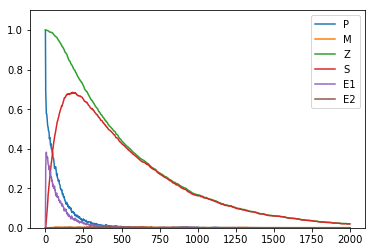

In [312]:
time_duration = 2000
dt = 2
repetitions = 2000

total_points = np.ceil(time_duration/np.float(dt) + 1).astype(int)
points = np.arange(total_points).astype(int)
t_array = np.float(dt) * points

num_states = 6

init_state = 0


pops = np.zeros([repetitions,total_points])
dtRateMat = np.float(dt)*rateMat

if np.max(dtRateMat) > 0.8:
    print 'dt not small enough! Probably gonna mess up'
    print 'dt should be no bigger than ', 0.8/np.max(rateMat)

st = time.time()

for jj in range(repetitions):
    rands = np.random.rand(total_points,num_states)
    evrands = np.random.rand(total_points)
    current_state = init_state
    rates = dtRateMat[current_state]
    for ii, rand in enumerate(rands):
        pops[jj,ii] = current_state
        decays = rand < rates
        events = np.where(decays)[0]
        n_events = np.size(events)
        if n_events == 1:
            current_state = events[0]
            rates = dtRateMat[current_state]
        elif n_events > 1:
            current_state = events[int(evrands[ii] * n_events)]
            rates = dtRateMat[current_state]
        

print time.time() - st

pops_expanded = np.zeros([repetitions,total_points,num_states])

for ind in range(num_states):
    pops_expanded[:,:,ind] = pops==ind

populations = np.mean(pops_expanded,axis = 0)
pops_to_plot = np.copy(populations)
pops_to_plot[:,2] = 1-pops_to_plot[:,2]
plt.figure()
plt.plot(t_array,pops_to_plot)
plt.legend(["P","M","Z","S","E1","E2"])
plt.ylim([0,1.1])
plt.show()

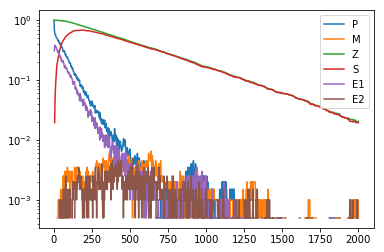

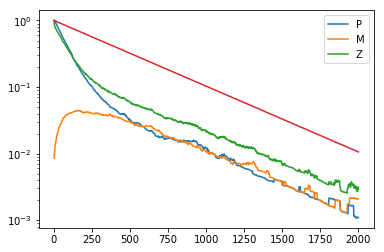

In [313]:
plt.figure()
plt.semilogy(t_array,pops_to_plot)
plt.legend(["P","M","Z","S","E1","E2"])
plt.show()

populations_after_decay = np.copy(populations)

populations_after_decay += np.outer(populations_after_decay[:,4],E1_branching)
populations_after_decay += np.outer(populations_after_decay[:,5],E2_branching)
populations_after_decay += np.outer(populations_after_decay[:,3],S_branching)

populations_after_decay[:,2] = 1- populations_after_decay[:,2]
plt.figure()
plt.semilogy(t_array,populations_after_decay[:,0:3])
plt.legend(["P","M","Z"])
plt.semilogy(t_array,np.exp(-t_array/S_lifetime))
plt.show()

In [314]:
Apar = -11.0
Aperp = 55
Larmor = 11*40

wp1 = 2*np.pi*1e-6*(np.sqrt((Larmor + Apar)**2 + Aperp**2) - Larmor)
wm1 = 2*np.pi*1e-6*(np.sqrt((Larmor - Apar)**2 + Aperp**2) - Larmor)

print wp1, wm1

-4.70530686958e-05 9.01089286879e-05


In [315]:
avgRepumpTime=np.sum(t_array[:-1]*(-1.0*np.diff(pops_to_plot[:,2])))

print avgRepumpTime

536.616


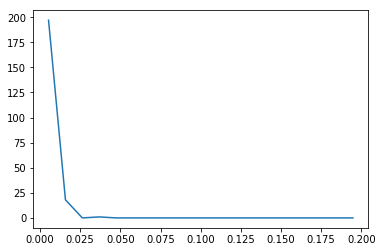

-0.0380626422403 0.0403258322705
-422.407
0.0483538928768


In [326]:
phase = dt*np.array([wm1,0,0,-1.0*wm1,0,0])
phaseAcquired = np.sum(np.dot(phase,np.transpose(pops_expanded,axes = [0,2,1])),axis=1)

h,bins =np.histogram(phaseAcquired,np.linspace(0.0,0.2,20))
centers = bins[:-1] + (bins[1]-bins[0])/2

plt.plot(centers,h)
plt.show()

meanPhase = np.mean(phaseAcquired)
stdDevPhase = np.sqrt(np.var(phaseAcquired))

print meanPhase, stdDevPhase

print meanPhase/wm1
print wm1*avgRepumpTime

In [183]:
def normalized(a, axis=-1):
    a = np.array(a)
    return a/np.linalg.norm(a, 1, axis)


In [184]:
def repumping_rateMat():
    
    # P,M,Z,S,E1,E2
    rateMat = np.zeros([num_states,num_states])

    # P to E1/E2 under drive
    rateMat[0,4] += Drive * drive_branching[0]
    rateMat[0,5] += Drive * drive_branching[1]
    rateMat[4,0] += Drive * drive_branching[0]
    rateMat[5,0] += Drive * drive_branching[1]
    # M to E1/E2 under drive
    rateMat[1,4] += Drive * drive_branching[1]
    rateMat[1,5] += Drive * drive_branching[0]
    rateMat[4,1] += Drive * drive_branching[1]
    rateMat[5,1] += Drive * drive_branching[0]
    # Spontaneous emission

    rateMat[3,:] += S_branching/S_lifetime
    rateMat[4,:] += E1_branching/E1_lifetime
    rateMat[5,:] += E2_branching/E2_lifetime

    return rateMat
